# Test simple MCMC inference

In [1]:
import zeus
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import numpy as np
import time
from multiprocessing import Pool
plt.style.use("ggplot")

import pyccl as ccl
import pandas as pd

In [2]:
# define the model function
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

# set the true values of the model parameters for creating the data
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

# Set the x-coordinates of the data points
M = 70 # Number of data points
x = np.sort(10.0 * np.random.rand(M)) # their x-coordinates

In [3]:
# create the data - the model plus Gaussian noise
sigma = 3.0 # standard deviation of the noise
data = straight_line(x, m_true, c_true) + sigma * np.random.randn(M)

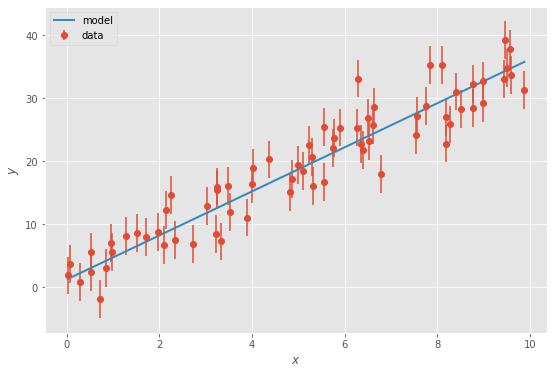

In [4]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [7]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

In [8]:
ndim = 2 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 3000 # Number of steps/iterations.

start = np.array([m_true, c_true]) + np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

In [6]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, loglike, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 3000/3000 [00:06<00:00, 484.98it/s]
Summary
-------
Number of Generations: 3000
Number of Parameters: 2
Number of Walkers: 10
Number of Tuning Generations: 36
Scale Factor: 1.196372
Mean Integrated Autocorrelation Time: 3.08
Effective Sample Size: 9732.18
Number of Log Probability Evaluations: 157402
Effective Samples per Log Probability Evaluation: 0.06183


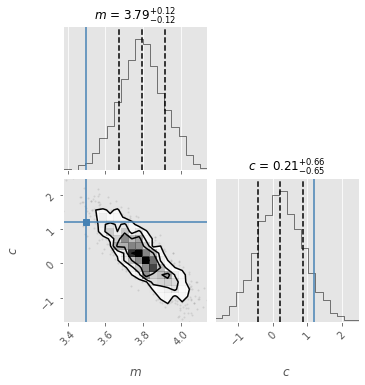

In [7]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//2, thin=10)

# plot marginal posterior distributions
#fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true]);
import corner
figure = corner.corner(chain, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(data, sigma, x))
sampler.run_mcmc(start, nsteps, progress=True);

100%|██████████| 3000/3000 [00:01<00:00, 1627.28it/s]


In [10]:
sampler.get_autocorr_time()

array([30.98487733, 32.12887656])

In [11]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

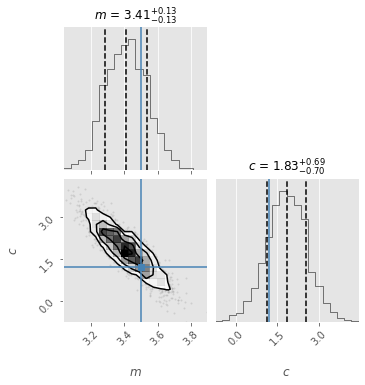

In [12]:
figure = corner(flat_samples, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

## Consider with prior

In [14]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

In [15]:
def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, data, sigma, x)

In [14]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 3000/3000 [00:07<00:00, 380.72it/s]
Summary
-------
Number of Generations: 3000
Number of Parameters: 2
Number of Walkers: 10
Number of Tuning Generations: 55
Scale Factor: 0.89687
Mean Integrated Autocorrelation Time: 3.07
Effective Sample Size: 9767.73
Number of Log Probability Evaluations: 163485
Effective Samples per Log Probability Evaluation: 0.059747


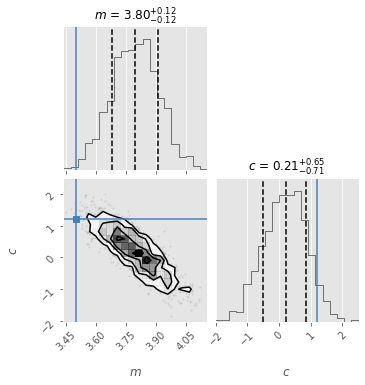

In [15]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain_bayes = sampler.get_chain(flat=True, discard=nsteps//2, thin=10)

# plot marginal posterior distributions
#fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true]);
import corner
figure = corner.corner(chain_bayes, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(data, sigma, x))
sampler.run_mcmc(start, nsteps, progress=True);

100%|██████████| 3000/3000 [00:01<00:00, 1813.40it/s]


In [17]:
flat_samples_bayes = sampler.get_chain(discard=100, thin=15, flat=True)

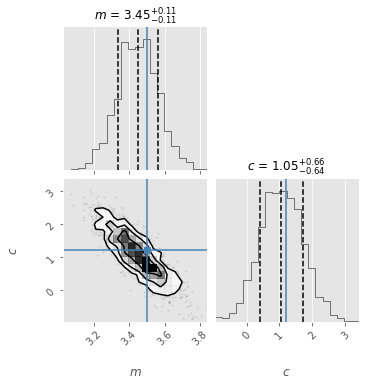

In [19]:
figure = corner(flat_samples_bayes, labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=[m_true, c_true])

# Multiprocessing

In [13]:
ndim = 5
nwalkers = 2 * ndim
nsteps = 100

def log_prob(x):
    time.sleep(0.003)
    return -0.5 * np.sum(x**2.0)

start = np.random.randn(nwalkers, ndim)

## With `zeus`

In [22]:
t0 = time.time()

sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(start, nsteps)

print("Serial took {0:.1f} seconds".format(time.time()-t0))

Initialising ensemble of 10 walkers...



Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]


Sampling progress :   1%|          | 1/100 [00:00<00:14,  6.99it/s]


Sampling progress :   2%|▏         | 2/100 [00:00<00:15,  6.35it/s]


Sampling progress :   3%|▎         | 3/100 [00:00<00:16,  6.03it/s]


Sampling progress :   4%|▍         | 4/100 [00:00<00:15,  6.06it/s]


Sampling progress :   5%|▌         | 5/100 [00:00<00:15,  6.31it/s]


Sampling progress :   6%|▌         | 6/100 [00:00<00:14,  6.45it/s]


Sampling progress :   7%|▋         | 7/100 [00:01<00:14,  6.28it/s]


Sampling progress :   8%|▊         | 8/100 [00:01<00:14,  6.24it/s]


Sampling progress :   9%|▉         | 9/100 [00:01<00:15,  5.96it/s]


Sampling progress :  10%|█         | 10/100 [00:01<00:14,  6.16it/s]


Sampling progress :  11%|█         | 11/100 [00:01<00:14,  6.01it/s]


Sampling progress :  12%|█▏        | 12/100 [00:01<00:14,  6.05it/s]


Sampling progress :  13%|█▎        | 13/100 [00:02<00

Serial took 16.3 seconds


In [23]:
t0 = time.time()

with Pool() as pool:
    sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler.run_mcmc(start, nsteps)

print("Multiprocessing took {0:.1f} seconds".format(time.time()-t0))

Initialising ensemble of 10 walkers...



Sampling progress :   0%|          | 0/100 [00:00<?, ?it/s]


Sampling progress :   2%|▏         | 2/100 [00:00<00:05, 18.12it/s]


Sampling progress :   5%|▌         | 5/100 [00:00<00:05, 18.95it/s]


Sampling progress :   8%|▊         | 8/100 [00:00<00:04, 19.51it/s]


Sampling progress :  10%|█         | 10/100 [00:00<00:04, 18.99it/s]


Sampling progress :  12%|█▏        | 12/100 [00:00<00:04, 19.26it/s]


Sampling progress :  14%|█▍        | 14/100 [00:00<00:04, 19.25it/s]


Sampling progress :  17%|█▋        | 17/100 [00:00<00:04, 19.38it/s]


Sampling progress :  19%|█▉        | 19/100 [00:00<00:04, 19.30it/s]


Sampling progress :  21%|██        | 21/100 [00:01<00:04, 19.23it/s]


Sampling progress :  23%|██▎       | 23/100 [00:01<00:04, 19.24it/s]


Sampling progress :  26%|██▌       | 26/100 [00:01<00:03, 19.66it/s]


Sampling progress :  28%|██▊       | 28/100 [00:01<00:03, 18.51it/s]


Sampling progress :  31%|███       | 31/100 [00

Multiprocessing took 5.3 seconds


## With `emcee`

In [14]:
def log_prob(theta):
    t = time.time() + np.random.uniform(0.005, 0.008)
    while True:
        if time.time() >= t:
            break
    return -0.5 * np.sum(theta ** 2)

In [15]:
np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

Serial took 21.2 seconds


In [16]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

64 CPUs


In [17]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [18]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|██████████| 100/100 [00:01<00:00, 57.27it/s]

Multiprocessing took 1.8 seconds
12.0 times faster than serial


# TODO 

Test `scipy.optimize`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [8]:
import scipy

In [10]:
%time res = scipy.optimize.minimize(log_prob, initial)

CPU times: user 18.1 s, sys: 43.9 ms, total: 18.2 s
Wall time: 16.8 s


In [14]:
res.x.shape

(160,)

In [15]:
initial.shape

(32, 5)

# Application in cosmology

In [2]:
import sys
sys.path.insert(1, '/home/tkarim/imaging-sys-covariance/src/')
#from lib import *
import params as pm

## Generate true values

In [3]:
b1_true = 1.75
Omega_c_true = 0.3
sigma8_true = 0.8

In [4]:
import itertools
def bin_mat(r=[],mat=[],r_bins=[]):
    """Sukhdeep's Code to bins data and covariance arrays

    Input:
    -----
        r  : array which will be used to bin data, e.g. ell values
        mat : array or matrix which will be binned, e.g. Cl values
        bins : array that defines the left edge of the bins,
               bins is the same unit as r

    Output:
    ------
        bin_center : array of mid-point of the bins, e.g. ELL values
        mat_int : binned array or matrix
    """

    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int


In [5]:
def cgll(ell, bias, **cosmo_kwargs):
    """Given a cosmology in pyccl generate clgg

    Inputs:
        b : linear bias
    """

    #define cosmology
    cosmo = ccl.Cosmology(**cosmo_kwargs)

    #read in dNdz
    dNdzddeg2 = pd.read_csv("../dat/nz_blanc.txt", sep=",")
    zmid = dNdzddeg2['Redshift_mid']
    dndz = dNdzddeg2['dndz/deg^2'] * 14000
    dn = dndz[:-1] * np.diff(zmid)  #redshift bin width

    #set constant bias
    b = bias*np.ones(len(zmid[:-1]))

    #Create CCL tracer object for galaxy clustering
    elg_ccl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zmid, dndz),
        bias=(zmid[:-1],b))

    #calculate theoretical Cls
    cls_elg_th = ccl.angular_cl(cosmo, elg_ccl, elg_ccl, ell)

    return cls_elg_th

In [6]:
%time theory_true = cgll(ell = pm.ell, bias = b1_true, Omega_c = Omega_c_true, \
         Omega_b = 0.0486, h = 0.6774, sigma8 = sigma8_true, n_s = 0.965, \
                   transfer_function = 'boltzmann_class')

CPU times: user 30.8 s, sys: 897 ms, total: 31.7 s
Wall time: 1.48 s


In [7]:
ELL_mid, theory_true_binned = bin_mat(pm.ell, theory_true, pm.ELL)

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [8]:
def variance_cl(ell, cl, fsky = .38):
    return (2./((2*ell + 1) * fsky))*(cl**2)

cov_full_diag = variance_cl(pm.ell, theory_true)

In [9]:
cov_full = np.zeros((pm.ell.shape[0], pm.ell.shape[0]))
np.fill_diagonal(cov_full, cov_full_diag)

_, cov_theory_true_binned = bin_mat(pm.ell, cov_full, pm.ELL)
icov_theory_true_binned = np.linalg.inv(cov_theory_true_binned)

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_t[slc]


In [27]:
np.save("icov_binned.npy", icov_theory_true_binned, allow_pickle=False)

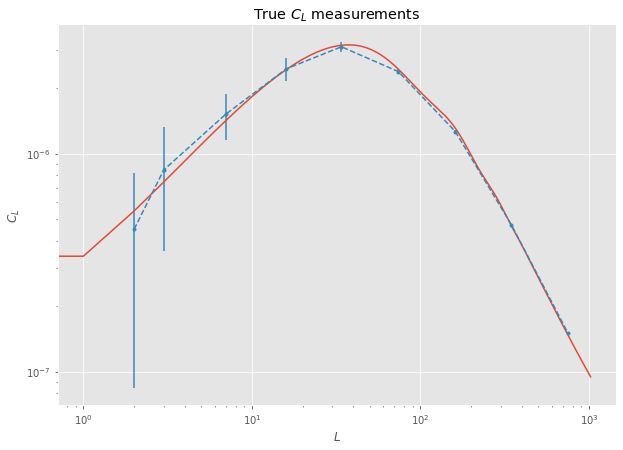

In [24]:
plt.figure(figsize=(10, 7))
plt.loglog(pm.ell, theory_true)
plt.errorbar(np.round(ELL_mid), theory_true_binned, yerr=np.sqrt(np.diag(cov_theory_true_binned)),
            ls = "--", marker = ".")
plt.title("True $C_{L}$ measurements")
plt.xlabel("$L$")
plt.ylabel("$C_L$")
plt.xscale("log")
plt.yscale("log")

## Define log likelihood

In [28]:
np.save("data_binned.npy", data_binned, allow_pickle=False)

In [11]:
data_binned = theory_true_binned
icov_binned = icov_theory_true_binned

def loglike(theta):
    """
    Returns log likelihood 
    
    Arguments:
        theta (list) : list of parameters to be inferred; b1, Omega_c and A_s
        data_binned (array) : observed pCls binned
        icov_binned (matrix) : inverse covariance matrix
    """
    
    #unpack model parameters
    Omega_c, sigma8 = theta
    
    #evaluate the model
    #theory = cgll(ell = pm.ell, bias = b1_true, Omega_c = Omega_c, \
    #     Omega_b = 0.0486, h = 0.6774, sigma8 = sigma8, n_s = 0.965, \
    #               transfer_function = 'bbks')
    theory = (Omega_c**0.3 + sigma8*.01)*pm.ell
    _, theory_binned = bin_mat(pm.ell, theory, pm.ELL)
    
    #return loglikelihood
    diff = theory_binned - data_binned
    return -0.5 * (diff).T @ icov_binned @ diff

In [14]:
loglike((0.83, 0.8))

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


-1.726626884784587e+24

## Inference with true values as data 

In [15]:
ndim = 2 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 5 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 10 # Number of steps/iterations.

start = np.array([Omega_c_true, sigma8_true]) + \
0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

In [16]:
sampler_emcee = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler_emcee.run_mcmc(start, nsteps, progress=True);

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
100%|██████████| 10/10 [00:00<00:00, 26.06it/s]


In [17]:
sampler_emcee.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.88904984 0.83947493]

In [40]:
flat_samples = sampler_emcee.get_chain(flat=True)
print(flat_samples.shape)

(50, 2)


In [41]:
from corner import corner

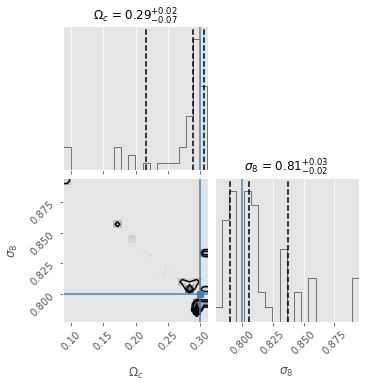

In [42]:
import corner

fig = corner.corner(
    flat_samples, labels=[r"$\Omega_c$", r"$\sigma_8$"], truths=[Omega_c_true, sigma8_true], 
    quantiles=np.array([.16, .5, .84]),
    show_titles=True, title_kwargs={"fontsize": 12}
);

## Multiprocess inference

In [18]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [19]:
with Pool() as pool:
    sampler_emcee_multi = emcee.EnsembleSampler(nwalkers, ndim, loglike, pool=pool)
    start_time = time.time()
    sampler_emcee_multi.run_mcmc(start, nsteps, progress=True)
    end_time = time.time()
    multi_time = end_time - start_time
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    #print("{0:.1f} times faster than serial".format(serial_time / multi_time))

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-inpu

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-inpu

<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-input-4-b0e3af1b7792>:49: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]
<ipython-inpu

Multiprocessing took 0.4 seconds


In [23]:
sampler_emcee_multi.get_chain()

(10, 5, 2)

### CCLX Example

In [16]:
import pyccl as ccl
import pandas as pd

In [17]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

ell = np.arange(2, 2000)
delta_ell = ell[1]-ell[0]
Ngal = 46. * 100.31 * (i_lim - 25.) * 3600 # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

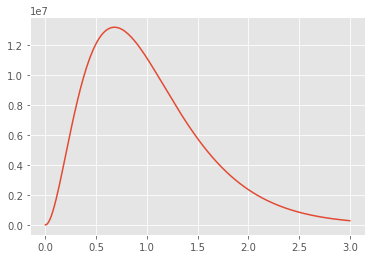

In [18]:
#plt.plot(tmpzmid, tmpdndz)
plt.plot(z, dNdz)

Text(0, 0.5, '$C_\\ell$')

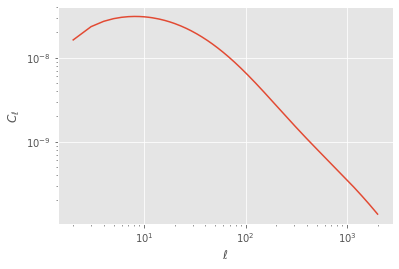

In [19]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96,  sigma8=0.83, transfer_function='bbks')

tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell) #C_ell



plt.plot(ell,data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

In [20]:
# C_ell^2/(Area of LSST survey*ell*delta ell)
cov = np.diag(data**2)*2*np.pi/((4*np.pi*18000)*(np.pi/180)**2*ell*delta_ell) 
icov = np.linalg.inv(cov) #inverse of cov

In [21]:
def lnprob(theta):
    for i in range(len(theta)):
        cosmo = ccl.Cosmology(
            Omega_c=theta[0], Omega_b=0.045, h=0.67, n_s=0.96, sigma8=theta[1], 
            transfer_function='bbks')
        
        tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        model = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
        diff = data-model
    return -np.dot(diff,np.dot(icov,diff))/2.0

In [22]:
ndim = 2
nwalkers = 5
p0 = [np.array([0.27,0.83])*np.ones(ndim)+np.array([0.05,0.1]) * np.random.rand() for i in range(nwalkers)] 
p0 = np.array(p0)
p0 = p0 - len(p0)*[[0.025,0.05]]

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
%time pos, prob, state = sampler.run_mcmc(p0, 10, skip_initial_state_check = True, progress = True)

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

CPU times: user 40min 53s, sys: 1min 15s, total: 42min 9s
Wall time: 44.4 s


Test with `scipy.optimize`

In [27]:
p0[1]

array([0.28828225, 0.8665645 ])

In [28]:
%time res = scipy.optimize.minimize(lnprob, p0[1])

CCLError: Error CCL_ERROR_ROOT: ccl_halofit.c: ccl_halofit_struct_new(): could not solve for non-linear scale for halofit at least once


In [22]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    start = time.time()
    sampler.run_mcmc(p0, 10, progress=True, skip_initial_state_check = True,)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    #print("{0:.1f} times faster than serial".format(serial_time / multi_time))

Process ForkPoolWorker-25:
Process ForkPoolWorker-28:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-35:
Process ForkPoolWorker-33:
Process ForkPoolWorker-47:
Process ForkPoolWorker-21:
Process ForkPoolWorker-9:
Process ForkPoolWorker-14:
Process ForkPoolWorker-63:
Process ForkPoolWorker-39:
Process ForkPoolWorker-24:
Process ForkPoolWorker-27:
Process ForkPoolWorker-31:
Process ForkPoolWorker-34:
Process ForkPoolWorker-18:
Process ForkPoolWorker-61:
Process ForkPoolWorker-15:
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-17:
Process ForkPoolWorker-36:
Process ForkPoolWorker-26:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-29:
Process ForkPoolWorker-37:
Process ForkPoolWorker-19:
Process ForkPoolWorker-64:
Process ForkPoolWorker-12:
Process ForkPoolWorker-54:
Process ForkPoolWorker-59:
Process ForkPoolWorker-46:
Process ForkPoolWorker-23:
Process ForkPoolWorker-10:
Proc

In [15]:
sampler.reset()

In [17]:
sampler.run_mcmc(pos, 100, rstate0=state, skip_initial_state_check = True);

In [18]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

Mean acceptance fraction: 0.7579999999999999


In [20]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

In [21]:
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))

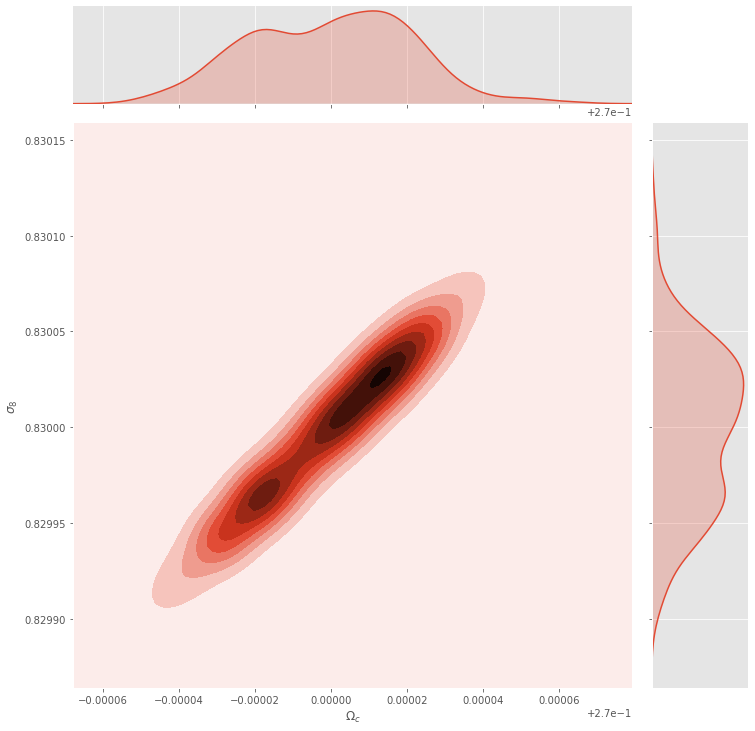

In [45]:
sns.jointplot(
    samples[:,0],
    samples[:,1],
    kind='kde',
    stat_func=None,
    height=10).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")

## Saving progress

In [34]:
import emcee
import numpy as np

np.random.seed(42)

# The definition of the log probability function
# We'll also use the "blobs" feature to track the "log prior" for each step
def log_prob(theta):
    log_prior = -0.5 * np.sum((theta - 1.0) ** 2 / 100.0)
    log_prob = -0.5 * np.sum(theta ** 2) + log_prior
    return log_prob, log_prior


# Initialize the walkers
coords = np.random.randn(32, 5)
nwalkers, ndim = coords.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, backend=backend)

In [35]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  6%|▌         | 5900/100000 [00:32<08:45, 179.09it/s]


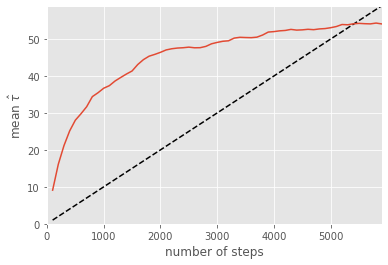

In [36]:
import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [1]:
info = {
    "likelihood": {
        "gaussian_mixture": {
            "means": [0.2, 0],
            "covs": [[0.1, 0.05],
                     [0.05, 0.2]],
            "derived": True}},
    "params": dict([
        ("a", {
            "prior": {"min": -0.5, "max": 3},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"dist": "norm", "loc": 0, "scale": 1},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta"}),
        ("derived_a", {
            "latex": r"\alpha^\prime"}),
        ("derived_b", {
            "latex": r"\beta^\prime"})]),
    "sampler": {
        "mcmc": None}}

In [2]:
from cobaya.run import run

updated_info, sampler = run(info)


[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 16400.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:1.054628, b:0
[mcmc] Sampling!
[mcmc] Progress @ 2021-08-30 18:50:48 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.174
[mcmc]  - Convergence of means: R-1 = 0.198033 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.

[root] *WARNING* outlier fraction 0.04411764705882353 
Mean:
[0.21616585 0.00809287]
Covariance matrix:
[[0.08950341 0.03847604]
 [0.03847604 0.16831453]]


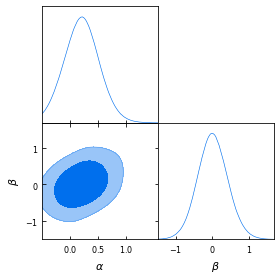

In [3]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["a", "b"], filled=True)

## Skylens notebook

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" #need to be set early

import sys
import emcee

from skylens import *
# from skylens.utils import *
from resource import getrusage, RUSAGE_SELF
import psutil
from distributed.utils import format_bytes

from dask.distributed import Lock

import faulthandler; faulthandler.enable()
    #in case getting some weird seg fault, run as python -Xfaulthandler something.py
    # problem is likely to be in some package

import multiprocessing
from distributed import LocalCluster
from dask.distributed import Client

import argparse

In [2]:
import pickle
from classy import Class
import matplotlib.pyplot as plt
import seaborn as sns
import asdf

from time import time

In [11]:
test_run = True

nwalkers=100
nsteps=100
python_file='mcmc_args.py'

if test_run:
    nzbins=2
    nwalkers=5
    nsteps=10
    python_file='mcmc_test_args.py'
    ncpu=25
    
eh_pk = True

In [4]:
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                                  memory_limit='120gb',dashboard_address=8801,processes=True)
client=client_get(scheduler_info=scheduler_info)
print('client: ',client)#,dask_dir,scheduler_info)
lock = None

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid57907/
client:  <Client: 'tcp://127.0.0.1:39277' processes=25 threads=25, memory=3.00 TB>


In [12]:
skylens_args=parse_python(file_name=python_file)

if eh_pk:
    print('mcmc will use eh_pk')
    skylens_args['pk_params']['pk_func']='eh_pk'
    skylens_args['scheduler_info']=scheduler_info

Scattering WT data 1
ns0:  27.0
[0.10002    0.10082016 0.10162032 ... 2.99819964 2.9989998  2.99979996] 100 5
source_tomo_bins, zmax 5.0 2.999799959991998 0.5999699939987997
Tracer utils has no tracers
Tracer utils has tracers:  ['galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'z_max': 4, 'use_astropy': True, 'Oml': 0.6925}
power spectra camb_pk
Win gen: step size 4 48 31.0 10
Window done. Size: 0.0
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
mcmc will use eh_pk


In [15]:
try:
    fname_cl=file_home+fname_out
    with open(fname_cl,'rb') as of:
        cl_all=pickle.load(of)
    Win=cl_all['Win']
    if do_pseudo_cl:
        cl_cov=cl_all['cov']
        cov_inv=np.linalg.inv(cl_cov.todense())
        data=cl_all['pcl_b']
    elif do_xi:
        xi_cov=cl_all['cov']
        cov_inv=np.linalg.inv(xi_cov.todense())
        data=cl_all['xi']
    zs_bin=cl_all['zs_bin']
    skylens_args['shear_zbins']=zs_bin
    print('read cl / cov from file: ',fname_cl)
except Exception as err:
        get_cov=True
        print('cl not found. Will compute',fname_cl,err)

NameError: name 'fname_cl' is not defined

In [17]:
if get_cov:    
    kappa0=Skylens(**skylens_args)
    print('kappa0 size',get_size_pickle(kappa0))#,kappa0.Win)
    print('kappa0.Ang_PS size',get_size_pickle(kappa0.Ang_PS))

    if do_xi:
        print('MCMC getting xi0G')
        xi0G=kappa0.xi_tomo()
        print('MCMC getting xi0 stack')
        xi_cov=client.compute(xi0G['stack']).result()
        cov_inv=np.linalg.inv(xi_cov['cov'].todense())
        data=xi_cov['xi']
    else:
        print('MCMC getting cl0G')
        cl0G=kappa0.cl_tomo()
        print('MCMC getting stack')
        cl_cov=client.compute(cl0G['stack']).result()
        cov_inv=np.linalg.inv(cl_cov['cov'].todense())
        data=cl_cov['pcl_b']

    Win=kappa0.Win
    outp['Win']=kappa0.Win
    outp['zs_bin']=kappa0.tracer_utils.z_bins['shear']
    with open(fname_cl,'wb') as of:
        pickle.dump(outp,of)
    del kappa0

Tracer utils has tracers:  ['shear', 'galaxy']


/home/tkarim/.local/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide


{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'Oml': 0.6925}
power spectra eh_pk
Win gen: step size 7 180 17.0 25
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'Oml': 0.6925}
power spectra eh_pk
Win gen: step size 1 24 17.0 25
Window done. Size: 0.0


/home/tkarim/.local/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
set binned measure done
Tracer utils has tracers:  ['shear', 'galaxy']
{'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684738813567, 'w': -1, 'wa': 0, 'T_cmb': <Quantity 2.7255 K>, 'Neff': 3.046, 'Oml': 0.6925}
power spectra eh_pk
Win gen: step size 7 180 17.0 25
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
wigner_files: {0: '/home/tkarim/SkyLens/temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 0.14215755462646484
set window_cl: cl done 1.2506194114685059 0.851 0.0
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 1

KeyError: 2

In [18]:
skylens_args

{'yaml_inp_file': None,
 'l': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191,